# $\S$ 11.6. Example: Simulated Data

We generated data from two additive error models $Y = f(X) + \epsilon$:
* $\text{Sum of sigmoids: } Y = \sigma(a_1^T X) + \sigma(a_2^T X) + \epsilon_1$;
* $\text{Radial: } Y = \prod_{m=1}^{10} \phi(X_m) + \epsilon_2$,

where $X^T = (X_1,X_2,\cdots,X_p) \sim N_p(\mathbf{0}, I)$, with $p=2$ for the first, $p=10$ for the second model.

* For the sigmoid model, $a_1^T = (3, 3)$ and $a_2^T = (3, -3)$;
* for the radial model, $\phi(t) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{t^2}{2})$.
* Both $\epsilon_1$ and $\epsilon_2$ are Gaussian errors, with variance chosen so that the SNR ratio  

  \begin{equation}
  \frac{\text{Var}(\text{E}(Y|X))}{\text{Var}(Y-\text{E}(Y|X))} = \frac{\text{Var}(f(X))}{\text{Var}(\epsilon)}
  \end{equation}

  is 4 in both models.

We took a training sample of size 100 and a test sample of size 10,000.

We fit neural networks with weights decay and various numbers of hidden units, and recorded the average test error

\begin{equation}
\text{E}_{\text{Test}} (Y-\hat{f}(X))^2
\end{equation}

for each of 10 random starting weights.

Only one training set was generated, but the results are typical for an "average" training set.

The test errors are shown in FIGURE 11.6.

In [14]:
import scipy
import scipy.stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

In [15]:
def sigmoid(x:scipy.ndarray)->scipy.ndarray:
    return scipy.reciprocal(1+scipy.exp(-x))


def generate_sigmoid_data(a1:scipy.ndarray,
                          a2:scipy.ndarray,
                          size_train:int,
                          size_test:int)->tuple:
    dim = 2
    train_x = scipy.randn(size_train, dim)
    train_y_true = sigmoid(train_x @ a1) + sigmoid(train_x @ a2)
    train_var = scipy.var(train_y_true)
    epsilon_var = train_var/4
    
    train_x_mean = train_x.mean(axis=0)
    train_x_std = train_x.std(axis=0)
    train_x_stdzd = (train_x - train_x_mean)/train_x_std

    test_x = scipy.randn(size_test, dim)
    test_y_true = sigmoid(test_x @ a1) + sigmoid(test_x @ a2)
    
    test_x_stdzd = (test_x - train_x_mean)/train_x_std
    # test_var = scipy.var(test_y_true)
    return (train_x_stdzd,
            train_y_true,
            train_y_true + scipy.randn(size_train)*scipy.sqrt(epsilon_var),
            test_x_stdzd,
            test_y_true,
            test_y_true + scipy.randn(size_test)*scipy.sqrt(epsilon_var),
            epsilon_var)


def generate_radial_data(size_train:int, size_test:int)->tuple:
    dim = 10
    train_x = scipy.randn(size_train, dim)
    train_y_true = scipy.stats.norm.pdf(train_x).prod(axis=1)
    train_var = scipy.var(train_y_true)
    epsilon_var = train_var/4
    
    train_x_mean = train_x.mean(axis=0)
    train_x_std = train_x.std(axis=0)
    train_x_stdzd = (train_x - train_x_mean)/train_x_std

    test_x = scipy.randn(size_test, dim)
    test_y_true = scipy.stats.norm.pdf(test_x).prod(axis=1)
    test_x_stdzd = (test_x - train_x_mean)/train_x_std
    # test_var = scipy.var(test_y_true)
    return (train_x_stdzd,
            train_y_true,
            train_y_true + scipy.randn(size_train)*scipy.sqrt(epsilon_var),
            test_x_stdzd,
            test_y_true,
            test_y_true + scipy.randn(size_test)*scipy.sqrt(epsilon_var),
            epsilon_var)

In [16]:
def init_weights(model):
    if isinstance(model, torch.nn.Linear):
        torch.nn.init.normal(model.weight.data)


def train(model:torch.nn.Module,
          loss_fn:torch.nn.Module,
          optimizer:torch.optim.Optimizer,
          epochs:int,
          torch_x:torch.autograd.Variable,
          torch_y:torch.autograd.Variable)->torch.nn.Module:
    model.apply(init_weights)  # Reset the model
    for epoch in range(epochs):
        model.zero_grad()
        
        y_pred = model(torch_x)

        loss = loss_fn(y_pred, torch_y)

        loss.backward()

        optimizer.step()
    
    # print(f'{niter} iterations done.')
    # print('loss with weight decay', loss.data[0])
    return loss


def test(model:torch.nn.Module,
         loss_fn:torch.nn.Module,
         torch_x_test:torch.autograd.Variable,
         torch_y_test:torch.autograd.Variable):
    y_pred = model(torch_x_test)
    return loss_fn(y_pred, torch_y_test)

In [17]:
class SigmoidModel(torch.nn.Module):
    def __init__(self, nhidden: int):
        super(SigmoidModel, self).__init__()
        self.lin1 = torch.nn.Linear(2, nhidden)
        self.lin2 = torch.nn.Linear(nhidden, 1)
        
    def forward(self, inputs):
        out = torch.nn.functional.sigmoid(self.lin1(inputs))
        out = self.lin2(out)
        return out
    
    
class RadialModel(torch.nn.Module):
    def __init__(self, nhidden: int):
        super(RadialModel, self).__init__()
        self.lin1 = torch.nn.Linear(10, nhidden)
        self.lin2 = torch.nn.Linear(nhidden, 1)
        
    def forward(self, inputs):
        out = torch.nn.functional.sigmoid(self.lin1(inputs))
        out = self.lin2(out)
        return out
#         return torch.nn.functional.sigmoid(out)

In [18]:
"""FIGURE 11.6. Boxplots of test error
The test error is displayed for 10 different starting weights,
for a single hidden layer neural network with the number of units as indicated.
"""
size_train = 100
size_test = 10000
learning_rate = .1

# Generate training data for sigmoid models
(train_x_sigmoid,
 train_y_true_sigmoid,
 train_y_sigmoid,
 test_x_sigmoid,
 test_y_true_sigmoid,
 test_y_sigmoid,
 errrate_bayes_sigmoid) = generate_sigmoid_data(scipy.array([3, 3]),
                                                scipy.array([3, -3]),
                                                size_train,
                                                size_test)

torch_x_sigmoid = torch.autograd.Variable(
    torch.from_numpy(scipy.stats.zscore(train_x_sigmoid)).float())
torch_y_sigmoid = torch.autograd.Variable(
    torch.from_numpy(train_y_sigmoid.reshape(size_train, 1)).float(),
    requires_grad=False)

torch_x_sigmoid_test = torch.autograd.Variable(
    torch.from_numpy(scipy.stats.zscore(test_x_sigmoid)).float(),
    requires_grad=False)
torch_y_sigmoid_test = torch.autograd.Variable(
    torch.from_numpy(test_y_sigmoid).float(),
    requires_grad=False)

# Generate training data for radial models
(train_x_radial,
 train_y_true_radial,
 train_y_radial,
 test_x_radial,
 test_y_true_radial,
 test_y_radial,
 errrate_bayes_radial) = generate_radial_data(size_train, size_test)

torch_x_radial = torch.autograd.Variable(
    torch.from_numpy(scipy.stats.zscore(train_x_radial)).float())
torch_y_radial = torch.autograd.Variable(
    torch.from_numpy(train_y_radial.reshape(size_train, 1)).float(),
    requires_grad=False)

torch_x_radial_test = torch.autograd.Variable(
    torch.from_numpy(scipy.stats.zscore(test_x_radial)).float(),
    requires_grad=False)
torch_y_radial_test = torch.autograd.Variable(
    torch.from_numpy(test_y_radial).float(),
    requires_grad=False)

In [19]:
train_x_radial.mean(axis=0)
train_x_radial.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [20]:
print(errrate_bayes_radial, errrate_bayes_sigmoid)

6.385216106201986e-12 0.07956872341099873


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


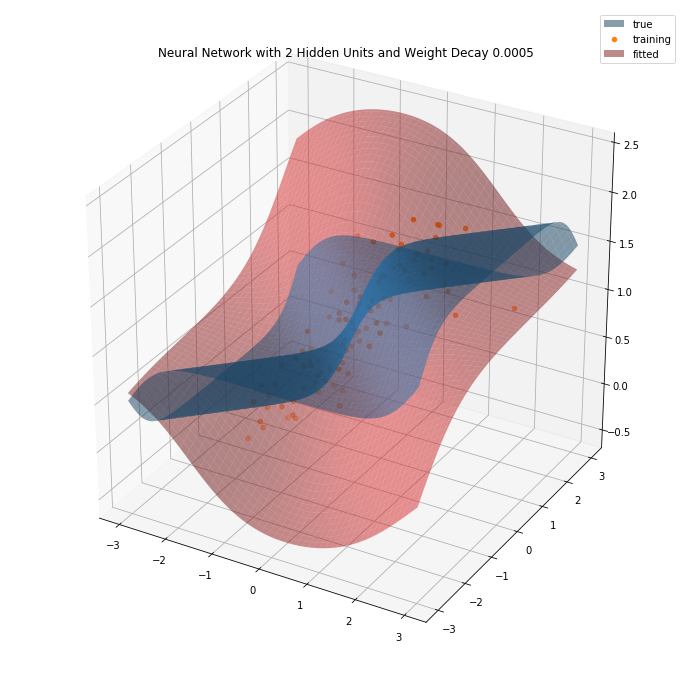

CPU times: user 2.6 s, sys: 89.3 ms, total: 2.69 s
Wall time: 2.67 s


In [21]:
%%time
# Try only the best model for plot
# We already know which model is the best (as the book said)
epochs = 1000
weight_decay = 0.0005

model = SigmoidModel(2)
# model = torch.nn.Sequential(torch.nn.Linear(2, 2, bias=False),
#                             torch.nn.ReLU(),
#                             torch.nn.Linear(2, 1, bias=False),
#                             torch.nn.Sigmoid())
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate,
                            weight_decay=weight_decay)
loss_fn = torch.nn.MSELoss()

# Train that model
loss = train(model, loss_fn, optimizer, epochs, torch_x_sigmoid, torch_y_sigmoid)

# Plot
linspace = scipy.linspace(-3, 3, 100)
meshgrid_x, meshgrid_y = scipy.meshgrid(linspace, linspace)
meshgrid_z_true = sigmoid(3*(meshgrid_x+meshgrid_y)) + sigmoid(3*(meshgrid_x-meshgrid_y))

fig1 = plt.figure(1, figsize=(12, 12))
ax1 = fig1.add_subplot(1, 1, 1, projection='3d')
surf_true = ax1.plot_surface(meshgrid_x, meshgrid_y, meshgrid_z_true, alpha=.5, label='true')
surf_true._facecolors2d = surf_true._facecolors3d
surf_true._edgecolors2d = surf_true._edgecolors3d
ax1.scatter3D(train_x_sigmoid[:, 0],
              train_x_sigmoid[:, 1],
              train_y_sigmoid, color='C1', label='training')

grid_x = scipy.array([[x,y] for x in linspace for y in linspace])
torch_grid_x = torch.autograd.Variable(torch.from_numpy(grid_x).float(),
                                       requires_grad=False)
fitted_grid_z = model(torch_grid_x).data.numpy() #.copy()
fitted_grid_z = fitted_grid_z.reshape(100, 100)
surf_fitted = ax1.plot_surface(meshgrid_x, meshgrid_y, fitted_grid_z,
                               color='C3', alpha=.5, label='fitted')
surf_fitted._facecolors2d = surf_fitted._facecolors3d
surf_fitted._edgecolors2d = surf_fitted._edgecolors3d
ax1.set_title('Neural Network with 2 Hidden Units and Weight Decay 0.0005')
ax1.legend()
plt.show()

In [ ]:
%%time
# Try every possible sigmoid model
errors_test_sigmoid = []
for nhidden in range(1, 11):
    errors_per_model = []
    for _ in range(10):
        model = SigmoidModel(nhidden)
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(),
                                    lr=learning_rate,
                                    weight_decay=weight_decay)
        train(model, loss_fn, optimizer, epochs, torch_x_sigmoid, torch_y_sigmoid)

        test_loss = test(model,
                         loss_fn,
                         torch_x_sigmoid_test,
                         torch_y_sigmoid_test)
        # print(model, test_loss)
#         errors_per_model.append(test_loss.data[0])
        errors_per_model.append(test_loss.data)
    errors_test_sigmoid.append(errors_per_model)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([10000])) that is different to the input size (torch.Size([10000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


CPU times: user 1min 11s, sys: 3.96 s, total: 1min 15s
Wall time: 1min 2s


In [ ]:
%%time
# Try every possible radial model
errors_test_radial = []
for nhidden in range(1, 11):
    errors_per_model = []
    for _ in range(10):
        model = RadialModel(nhidden)
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(),
                                    lr=learning_rate,
                                    weight_decay=weight_decay)
        train(model, loss_fn, optimizer, epochs, torch_x_radial, torch_y_radial)

        test_loss = test(model,
                         loss_fn,
                         torch_x_radial_test,
                         torch_y_radial_test)
#         errors_per_model.append(test_loss.data[0])
        errors_per_model.append(test_loss.data)
    errors_test_radial.append(errors_per_model)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([10000])) that is different to the input size (torch.Size([10000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


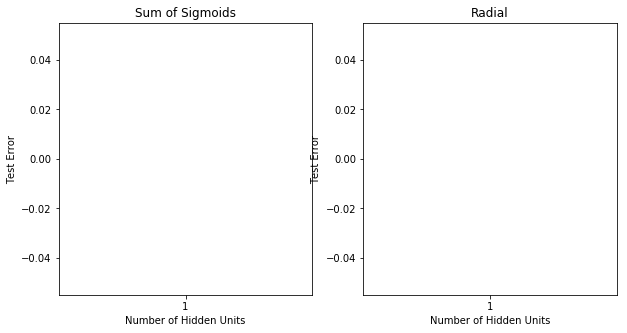

In [13]:
"""Results for the radial models explode, and I don't know why."""
fig2 = plt.figure(2, figsize=(10, 5))
ax21 = fig2.add_subplot(1, 2, 1)
ax21.boxplot((errors_test_sigmoid/errrate_bayes_sigmoid).T)
ax21.set_xlabel('Number of Hidden Units')
ax21.set_ylabel('Test Error')
ax21.set_title('Sum of Sigmoids')

ax22 = fig2.add_subplot(1, 2, 2)
ax22.boxplot((errors_test_radial/errrate_bayes_radial).T)
ax22.set_xlabel('Number of Hidden Units')
ax22.set_ylabel('Test Error')
ax22.set_title('Radial')
plt.show()

### Results & interpretation

In this example we used a fixed weights decay parameter of 0.0005, representing a mild amount of regularization. The results in the left panel suggest that more regularization is needed with greater numbers of hidden units.

#### The sigmoids model

Note that the zero hidden unit model refers to linear least squares model. The neural network is perfectly suited to the sum of sigmoids model, and the two-unit model does perform the best, achieving an error close to the Bayes rate (Recall that the Bayes rate for regression with squared error is the error variance; in the figures, we report test error relative to the Bayes error).

Notice, however, that with more hidden units, overfitting quickly creeps in, and with some starting weights the model does worse than the linear model (zero hidden unit) model. Even with two hidden units, two of the ten starting weight configurations produced results no better than the linear model, confirming the importance of multiple starting values.

#### The radial model

> A radial function is in a sense the most difficult for the neural net, as it is spherically symmetric and with no preferred directions.

We see in the right panel that it does poorly in this case, with the test error staying well above the Bayes error. In fact, since a constant fit (such as the sample average) achieves a relative error of 5 (when the SNR is 4), we see that the neural networks perform increasingly worse than the mean.

### Experiment on weight decay

In FIGURE 11.7 we repeated the experiment for the sum of sigmoids model, with no weights decay in the left panel, and stronger weight decay ($\lambda = 0.1$) in the right panel.

With no weight decay, overfitting becomes even more severe for larger numbers of hidden units. The weight decay value $\lambda = 0.1$ produces good results for all numbers of hidden units, and there does not appear to be overfitting as the number of units increases.

In [13]:
%%time
"""FIGURE 11.7. Boxplots of test error for the sigmoid model with and without weight decay.
The test error is displayed for ten different starting weights,
for a single hidden layer neural network with the number of units as indicated."""
errors_test_nowd = []
for nhidden in range(1, 11):
# for model, optimizer in zip(models_sigmoid_nowd, optimizers_sigmoid_nowd):
    errors_per_model = []
    for _ in range(10):
        model = SigmoidModel(nhidden)
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(),
                                    lr=learning_rate)
        train(model, loss_fn, optimizer, epochs, torch_x_sigmoid, torch_y_sigmoid)

        test_loss = test(model,
                         loss_fn,
                         torch_x_sigmoid_test,
                         torch_y_sigmoid_test)
        errors_per_model.append(test_loss.data[0])
    errors_test_nowd.append(errors_per_model)
    
errors_test_wd = []
for nhidden in range(1, 11):
# for model, optimizer in zip(models_sigmoid_wd, optimizers_sigmoid_wd):
    errors_per_model = []
    for _ in range(10):
        model = SigmoidModel(nhidden)
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(),
                                    lr=learning_rate,
                                    weight_decay=.1)
        train(model, loss_fn, optimizer, epochs, torch_x_sigmoid, torch_y_sigmoid)

        test_loss = test(model,
                         loss_fn,
                         torch_x_sigmoid_test,
                         torch_y_sigmoid_test)
        errors_per_model.append(test_loss.data[0])
    errors_test_wd.append(errors_per_model)

CPU times: user 31.8 s, sys: 2.19 s, total: 34 s
Wall time: 29.8 s


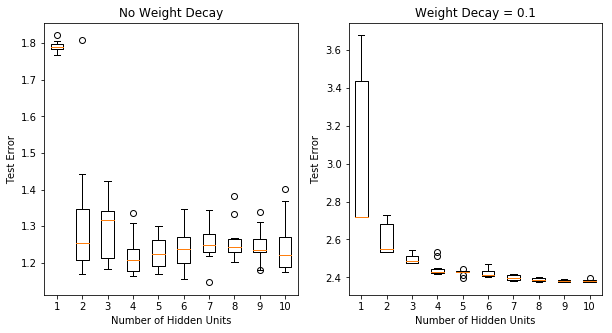

In [14]:
fig3 = plt.figure(3, figsize=(10, 5))
ax31 = fig3.add_subplot(1, 2, 1)
ax31.boxplot((errors_test_nowd/errrate_bayes_sigmoid).T)
ax31.set_xlabel('Number of Hidden Units')
ax31.set_ylabel('Test Error')
ax31.set_title('No Weight Decay')

ax32 = fig3.add_subplot(1, 2, 2)
ax32.boxplot((errors_test_wd/errrate_bayes_sigmoid).T)
ax32.set_xlabel('Number of Hidden Units')
ax32.set_ylabel('Test Error')
ax32.set_title('Weight Decay = 0.1')
plt.show()

Finally, FIGURE 11.8 shows the test error for a ten hidden unit network, varying the weight decay parameter over a wide range. The value 0.1 is approximately optimal.

In [15]:
"""FIGURE 11.8. Boxplots of test error for 10 hidden units network.
The test error is displayed for ten different starting weights,
for a single hidden neural network with ten hidden units and
weights decay parameter value as indicated."""
errors_test_10wd = []
wds = scipy.arange(0, 0.161, 0.01)
for wd in wds:
    errors_per_model = []
    for _ in range(10):
        model = SigmoidModel(10)
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(),
                                    lr=learning_rate,
                                    weight_decay=wd)
        train(model, loss_fn, optimizer, epochs, torch_x_sigmoid, torch_y_sigmoid)

        test_loss = test(model,
                         loss_fn,
                         torch_x_sigmoid_test,
                         torch_y_sigmoid_test)
        
        errors_per_model.append(test_loss.data[0])
    errors_test_10wd.append(errors_per_model)

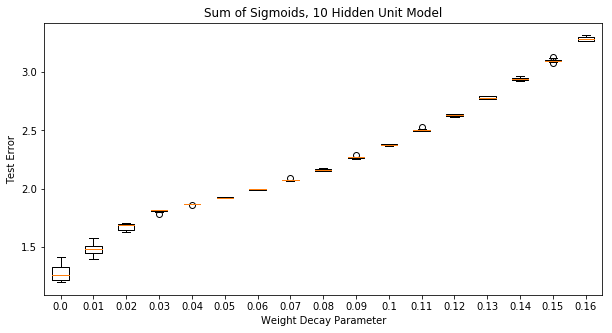

In [18]:
"""OMG, this plot completely goes in a reverse way ;("""
fig4 = plt.figure(4, figsize=(10, 5))
ax41 = fig4.add_subplot(1, 1, 1)
ax41.boxplot((errors_test_10wd/errrate_bayes_sigmoid).T,
             labels=wds)
ax41.set_xlabel('Weight Decay Parameter')
ax41.set_ylabel('Test Error')
ax41.set_title('Sum of Sigmoids, 10 Hidden Unit Model')
plt.show()

### Practice on selecting free parameters

In summary, there are two free parameters to select:
* The weight decay $\lambda$ and
* the number of hidden units $M$.

As a learning strategy, one could fix either parameter at the value corresponding to the least constrained model, to ensure that the model is rich enough, and use cross-validation to choose the other parameter.

Here the least constrained values are zero weight decay and ten hidden units. Comparing the left panel of FIGURE 11.7 to 11.8, we see that the test error is less sensitive to the value of the weight decay parameter, and hence cross-validation of this parameter would be preferred.